# CLASSIFICAÇÃO MULTICLASSE - K-Nearest Neighbors (kNN)
### Problema: dentificação de atividade humana usando dados de smartphones

- Guilherme Teixeira Semissatto
- RA: 140656
- semissatto@gmail.com

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
trainX_df = pd.read_fwf('./Dados/har_smartphone/X_train.txt', header = None)
testX_df = pd.read_fwf('./Dados/har_smartphone/X_test.txt', header = None)
trainY_df = pd.read_csv('./Dados/har_smartphone/y_train.txt', header = None)
testY_df = pd.read_csv('./Dados/har_smartphone/y_test.txt', header = None)

In [3]:
print (testX_df.shape, trainX_df.shape, trainY_df.shape, testY_df.shape)

(2947, 561) (7352, 561) (7352, 1) (2947, 1)


In [4]:
trainX = trainX_df.values
trainY = trainY_df.values
testX = testX_df.values
testY = testY_df.values
print (testX.shape, trainX.shape, trainY.shape, testY.shape)

(2947, 561) (7352, 561) (7352, 1) (2947, 1)


In [5]:
''' subtrai 1 dos valores de saída para ficar de acordo com o enunciado que segue:
# 0 – caminhada; 1 – subindo escadas;
# 2 – descendo escadas; 3 – sentado; 
# 4 – em pé; 5 – deitado '''

for i in range(len(trainY)):
    trainY[i] = trainY[i] - 1

for i in range(len(testY)):
    testY[i] = testY[i] - 1

### kNN pseudo-código
- 1. Load the Data.
- 2. Initialize the value of K.
- 3. For predicting the output class for the test data, iterate from 1st data point to the total number of data points.
      -  Calculate distance between test data and each row of training data by the help of euclidean distance.
      -  Sort the calculated distance in ascending order.
      -  Get the top K rows from the sorted array.
      -  Now find out the most frequent class of the rows.
      -  Return the predicted class for the test data.

In [6]:
def euclidian_distance(x_test, x_train):
    ''' Calcula as distâncias entre a instância de teste e os dados bases '''
    dist = 0
    dist = np.square(x_test - x_train)
    row_sum = np.sum(dist, axis = 1).reshape(1, -1) 
    return np.sqrt(row_sum)

In [7]:
def get_lowest_dist_indexes(array, k):
    return np.argsort(array)[0][:k]

In [8]:
def get_labels(indexes, y):
    ''' Obtém a classe correspondente a partir do index '''
    labels = np.zeros(len(indexes))
    for i in range(len(indexes)):
        labels[i] = y[indexes[i]]
    return labels

In [9]:
from scipy import stats
def winner_class(labels):
    ''' Retorna a classe mais frequente dos k-vizinhos '''
    return int(stats.mode(labels)[0])

In [10]:
def print_error(ŷ, y):
    ''' Imprime na tela as taxas de acerto/erro de classificação '''
    acerto = 0
    erro = 0
    for i in range(len(ŷ)):
        if int(ŷ[i]) == int(y[i]):
            acerto += 1
        else:
            erro += 1
    print("acertos:\t", acerto, "\nerros:\t\t", erro, "\nerro(%):\t", 100*erro/(acerto+erro))
    
def calc_error(ŷ, y):
    ''' Retorna a taxa de erro '''
    acerto = 0
    erro = 0
    for i in range(len(ŷ)):
        if int(ŷ[i]) == int(y[i]):
            acerto += 1
        else:
            erro += 1
    return erro/(acerto+erro)

In [11]:
def zero_one_loss(y, ŷ):
    ''' Calcula quão diferente está a estimativa de classe da classe real
        a partir da norma do vetor diferença (esperado - estimado)'''
    diff = (y - ŷ)
    norma = np.dot(diff.T, diff)/2
    soma_linha = np.sum(abs(norma), axis = 1)
    total_error = np.sum(soma_linha)
    loss = total_error/len(y)
    return loss

In [12]:
def one_hot_encoder(data):
    ''' Recebe dados categorizados (inteiros) e retorna um vetor one-hot. Exemplo [3]-> [0, 0, 0, 1, 0, 0]'''
    encoded = np.matrix(np.zeros(len(data)*int(max(data)+1))).reshape((len(data), int(max(data)+1)))
    for i in range(len(data)):
        max_index = data[i]
        encoded[i, max_index] = 1
    return encoded

In [13]:
def one_hot_decoder(data):
    ''' Recebe vetor one-hot e converte para categoria. Exemplo [0, 0, 0, 1, 0, 0] -> [3]'''
    decoded = np.zeros(data.shape[0]).reshape(-1,1)
    for i in range(len(data)):
        decoded[i] = np.argmax(data[i])
    return decoded     

### Geração da matriz de distâncias
- Para obter os vizinhos mais próximos, calcula-se, para cada amostra de teste, todas distâncias desta amostra para todos pontos do dataset de treino
- o código abaixo tem como resultado uma matriz NxM, sendo N o número de amostras de teste e M o número de amostras de treino
- o $N_t_h,M_t_h$ elemento é a distância da amostra de teste N para a amostra M do dataset de treino

In [14]:
number_of_features = trainX.shape[1]
m = trainX.shape[0]
n = testX.shape[0]
dists = [] # dists será uma matrix n x m

for i in range(n):
    dists.append(euclidian_distance(testX[i], trainX))

In [15]:
k_neighbors = np.arange(1, 100, 2)
ŷ = np.zeros(n, dtype = np.int8)
errors = []
losses = []

for k in range(len(k_neighbors)):    
    for i in range(n):
        lowest_idx = get_lowest_dist_indexes(dists[i], k_neighbors[k])
        lowest_labels = get_labels(lowest_idx, trainY)
        ŷ[i] = winner_class(lowest_labels)
    
    error = calc_error(ŷ, testY)
    errors.append(error)
    y_dec = one_hot_encoder(testY)
    ŷ_dec = one_hot_encoder(ŷ)
    loss = zero_one_loss(y_dec, ŷ_dec)
    losses.append(loss)

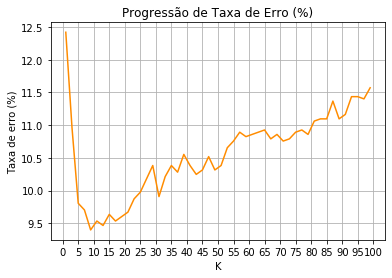

In [16]:
errors = np.array(errors)
plt.plot(k_neighbors, 100*errors, color = "darkorange")
plt.xticks(np.arange(0,105,5))
plt.xlabel("K")
plt.ylabel("Taxa de erro (%)")
plt.title("Progressão de Taxa de Erro (%)")
plt.grid(True)

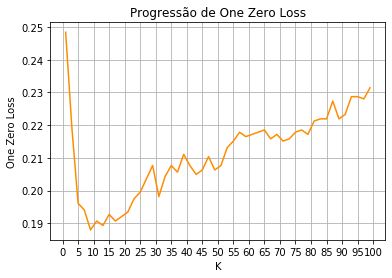

In [17]:
losses = np.array(losses)
plt.plot(k_neighbors, losses, color = "darkorange")
plt.xticks(np.arange(0,105,5))
plt.xlabel("K")
plt.ylabel("One Zero Loss")
plt.title("Progressão de One Zero Loss")
plt.grid(True)

In [18]:
errors = np.array(errors)
print("len(errors): ", len(errors))
print("argmin(errors): ", np.argmin(errors))
print("errors(argmin(erros)): ", errors[np.argmin(errors)])
print("k_neighbors(argmin(erros)): ", k_neighbors[np.argmin(errors)])

len(errors):  50
argmin(errors):  4
errors(argmin(erros)):  0.09399389209365457
k_neighbors(argmin(erros)):  9


### Do resultado acima, observamos que o melhor valor de k-vizinhos é 9. Vamos avaliar as métricas de `taxa de erro (%)` e sua `matriz de confusão`:

In [19]:
for i in range(n):
    lowest_idx = get_lowest_dist_indexes(dists[i], 9)
    lowest_labels = get_labels(lowest_idx, trainY)
    ŷ[i] = winner_class(lowest_labels)

In [20]:
print_error(ŷ,testY)

acertos:	 2670 
erros:		 277 
erro(%):	 9.399389209365456


### Matriz de confusão
- A matriz de confusão explora as métricas de um classificador. Em sua diagonal principal temos os acertos (Verdadeiro Positivo e Verdadeiro Negativo). Enquanto na diagonal anti-principal temos os erros do modelo (Falso positivo e Falso Negativo)

In [21]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
y_true = testY
y_pred = ŷ
multilabel_confusion_matrix(y_true, y_pred, labels = np.unique(testY))
confusion_matrix(y_true, y_pred, labels = np.unique(testY))

array([[485,   1,  10,   0,   0,   0],
       [ 37, 429,   5,   0,   0,   0],
       [ 47,  41, 332,   0,   0,   0],
       [  0,   4,   0, 395,  92,   0],
       [  0,   0,   0,  37, 495,   0],
       [  0,   0,   0,   2,   1, 534]])

# Área reservada para testes de código

In [22]:
# teste da função de distância Euclidiana v2
vetor1 = np.array([[1, 2, 3, 10], [2, 3, 6, 8]], dtype = np.int8)
vetor2 = np.array([[3, 4, 5, 20], [5, 7, 8, 9]], dtype = np.int8)
dist = euclidian_distance(vetor1, vetor2)
print("dist: ", dist)

dist:  [[10.58300524  5.47722558]]


In [23]:
# teste da função get_labels:
labels = get_labels(get_lowest_dist_indexes(dists[0], 3), trainY)
print (labels)

[4. 4. 4.]


In [24]:
# teste da função da classe vencedora
labels = get_labels(get_lowest_dist_indexes(dists[00], 3), trainY)
c = winner_class(labels)
c

4